In [1]:
# Download Seurat PBMC3k if not already downloaded
if (!dir.exists("data/filtered_gene_bc_matrices")) {
    dir.create("data", showWarnings = FALSE)
    download.file(
        url = "https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz",
        destfile = "data/pbmc3k_filtered_gene_bc_matrices.tar.gz")
    untar(tarfile = "data/pbmc3k_filtered_gene_bc_matrices.tar.gz", exdir = "data")
}

In [ ]:
library(dplyr)
library(Seurat)
library(patchwork)
library(ggplot2)
library(RColorBrewer)

In [ ]:
# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "data/filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)

# QC
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

# Normalize, identify variable features, and scale.
pbmc <- pbmc %>% 
    NormalizeData() %>%
    FindVariableFeatures(selection.method = "vst", nfeatures = 2000) %>%
    ScaleData(features = rownames(.))

In [ ]:
# Dim-reduce and cluster
pbmc <- pbmc %>% 
    RunPCA(features = VariableFeatures(object = .)) %>%
    FindNeighbors(dims = 1:10) %>% 
    FindClusters(resolution = 0.5) %>% 
    RunUMAP(dims = 1:10)

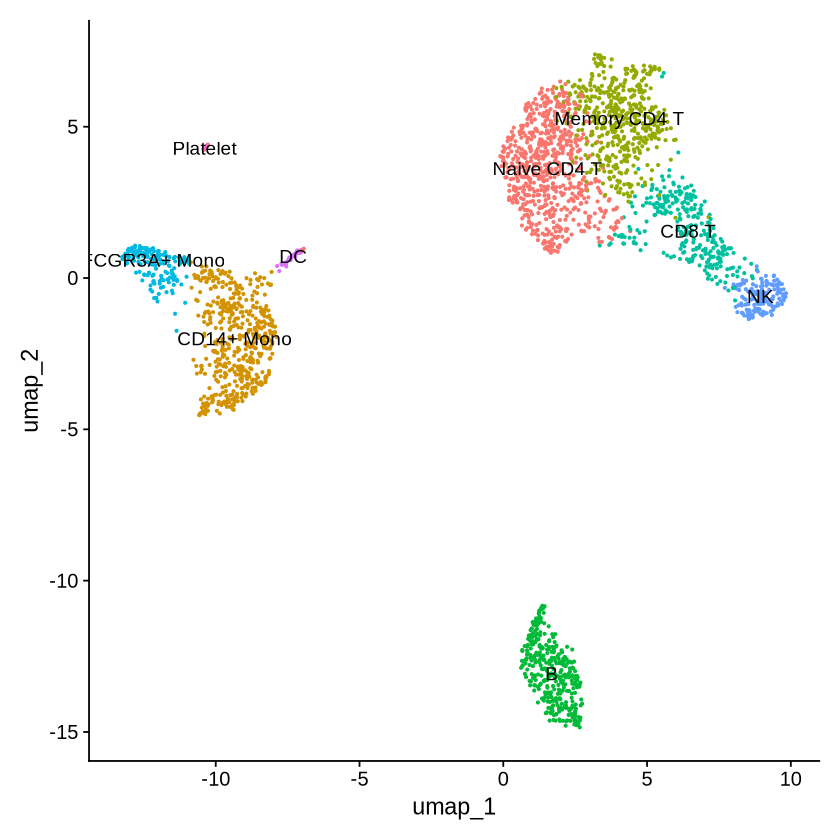

In [5]:
new.cluster.ids <- c(
  "Naive CD4 T", 
  "CD14+ Mono", 
  "Memory CD4 T", 
  "B", 
  "CD8 T", 
  "FCGR3A+ Mono",
  "NK", 
  "DC", 
  "Platelet"
)

# rename and plot
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
pbmc$celltype <- Idents(pbmc)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

In [6]:
# DEG analysis
pbmc.markers <- FindAllMarkers(pbmc, verbose = FALSE)

num_deg <- pbmc.markers %>% 
    filter(abs(avg_log2FC) > 0.5, p_val_adj < 0.05) %>%
    group_by(cluster) %>%
    summarise(num_deg = n()) %>%
    setNames(c("celltype", "num_deg"))

num_cell <- pbmc$celltype %>% 
    table %>% 
    as.data.frame %>% 
    setNames(c("celltype", "num_cell"))

DEG_df <- merge(num_deg, num_cell, by = "celltype")
DEG_df


celltype,num_deg,num_cell
<fct>,<int>,<int>
B,718,344
CD14+ Mono,1366,481
CD8 T,296,291
DC,672,32
FCGR3A+ Mono,1180,162
Memory CD4 T,473,476
Naive CD4 T,907,684
NK,572,155
Platelet,437,13


In [7]:
corrected_deg <- function(DEG_df, celltype_color) {
  # modeling linear regression
  model <- lm(num_deg ~ num_cell, data = DEG_df)
  
  # calculating residuals for each cell type
  DEG_df$residuals <- residuals(model)
  
  # ranking cell type
  DEG_df_rank <- DEG_df %>%
    arrange(desc(residuals)) %>%
    mutate(rank = row_number())
  
  # plotting rankplot
  ggplot(DEG_df_rank, aes(x = rank, y = residuals, color = celltype)) +
    geom_point(size = 3) +
    geom_line(aes(group = celltype)) +
    geom_text(aes(label = celltype), vjust = -1, hjust = 0.2, size = 3, color = "black") +
    scale_color_manual(values = celltype_color) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
    labs(x = "Rank",
         y = "Corrected Number of DEGs") +
    theme_classic()
}



`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


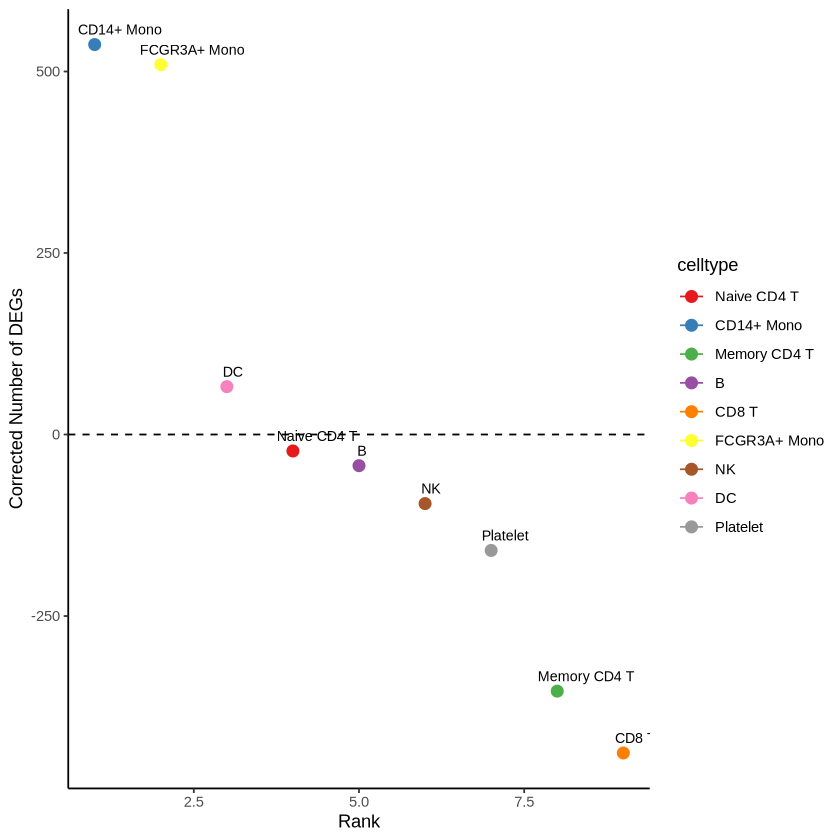

In [8]:
corrected_deg(DEG_df, brewer.pal(9, "Set1"))

In [9]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/baekjh/.miniforge3/envs/adiformer/lib/libmkl_rt.so.2

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] RColorBrewer_1.1-3 ggplot2_3.5.0      patchwork_1.2.0    Seurat_5.0.2      
[5] SeuratObject_5.0.1 sp_2.1-3           dplyr_1.1.4       

loaded via a namespace (and not attached):
  [1] Rtsne_0.17             colorspace_2.1-0       deldir_2.0-4          
  [4] ellipsis_0.3.2         ggridges_0.5.6   